# Transformer Model
Training a transformer model to forecast time series sequence of stock closing price  
Using 10 timesteps to forecast 1 forward timestep

Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

Load data and set global variables

In [2]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

df = pd.read_csv('FB_raw.csv') # data path of facebook stock price (Apr 2019 - Nov 2020)
close = np.array(df['close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

Plot shows the reduced scale of the closing prices

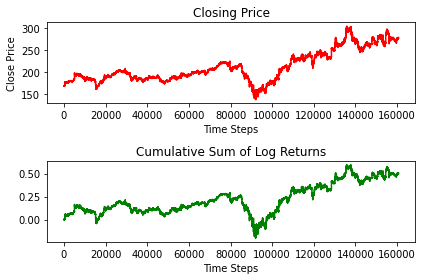

In [3]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

Positional Encoder

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]        

Transformer Model

In [5]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

Window function, split data into sequence window

In [6]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

Split data in training and testing, prepared in windowed sequences and pass through GPU

In [7]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data
    
    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

Split into training batches

In [8]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

Training function

In [9]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

Evaluation function for model after training

In [10]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

Function to forecast 1 time step from window sequence

In [11]:
def model_forecast(model, seqence):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

Function to forecast entire sequence

In [12]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

Prepare data for training model

In [13]:
train_data, val_data = get_data(logreturn, 0.6) # 60% train, 40% test split
model = TransAm().to(device)

Model parameters

In [14]:
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  150 # Number of epochs

Training loop

In [15]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step() 


C:\Users\Caspar\Desktop\python_project\venv\lib\site-packages\torch\optim\lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
| epoch   1 |    77/  385 batches | lr 0.0000500000 | 33.45 ms | loss 0.0702613
| epoch   1 |   154/  385 batches | lr 0.0000500000 | 24.37 ms | loss 0.0246598
| epoch   1 |   231/  385 batches | lr 0.0000500000 | 24.29 ms | loss 0.0123153
| epoch   1 |   308/  385 batches | lr 0.0000500000 | 24.59 ms | loss 0.0069573
| epoch   1 |   385/  385 batches | lr 0.0000500000 | 24.35 ms | loss 0.0190992
--------------------------------------------------------------------------------
| end of epoch   1 | time: 10.10s
--------------------------------------------------------------------------------
| epoch   2 |    77/  385 batches | lr 0.0000451250 | 26.62 ms | loss 0.0077980
| epoch   2 |   154/  385 batches | lr 0.0000451250 | 2

In [16]:
test_result, truth = forecast_seq(model, val_data)

125.98971390724182 sec


Plot forecasted sequence vs actual

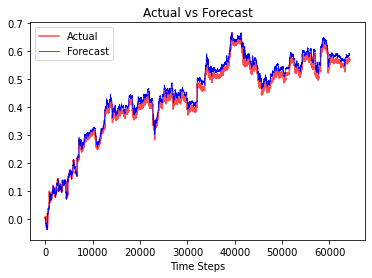

In [17]:
plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

Test random sequence

In [18]:
r = np.random.randint(100000, 160000)
test_forecast = model_forecast(model, csum_logreturn[r: r+10]) # random 10 sequence length

print(f"forecast sequence: {test_forecast}")
print(f"Actual sequence: {csum_logreturn[r: r+11]}")

forecast sequence: [0.48114383 0.48132795 0.4813648  0.4802595  0.48029637 0.48000145
 0.48202735 0.48158568 0.4816225  0.48213774 0.5065902 ]
Actual sequence: [0.48114383 0.48132796 0.48136478 0.48025952 0.48029638 0.48000145
 0.48202735 0.48158568 0.4816225  0.48213773 0.48125431]


Save model

In [19]:
torch.save(model.state_dict(), "transformer_ts.pth")

Load model

In [20]:
model2 = TransAm() # rename as model2
model2.load_state_dict(torch.load("transformer_ts.pth"))
model2.to(device)

TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (

Testing model on Boeing stock from the same time period

In [21]:
df2 = pd.read_csv('BA_raw.csv') # Boeing Co stock
close2 = df2['close'].fillna(method = 'ffill')
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

In [22]:
train_data2, val_data2 = get_data(logreturn2, 0.6)
test2_eval = evaluate(model2, val_data2)
print(f'Test 2 loss: {test2_eval :.5f}')

Test 2 loss: 0.00008


125.28154563903809 sec


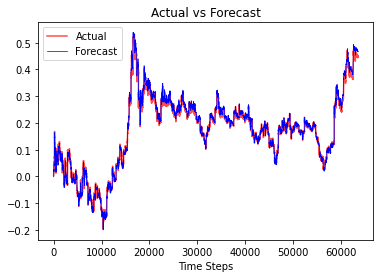

In [23]:
test_result2, truth2 = forecast_seq(model2, val_data2)

plt.plot(truth2, color='red', alpha=0.7)
plt.plot(test_result2, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

Testing model on JPMorgan stock from the same time period

In [24]:
df3 = pd.read_csv('JPM_raw.csv') # JPMorgan Chase & Co stock
close3 = df3['close'].fillna(method = 'ffill')
close3 = np.array(close3)
logreturn3 = np.diff(np.log(close3))

In [25]:
train_data3, val_data3 = get_data(logreturn3, 0.6)
test3_eval = evaluate(model2, val_data3)
print(f'Test 3 loss: {test3_eval :.5f}')

Test 3 loss: 0.00001


127.89451098442078 sec


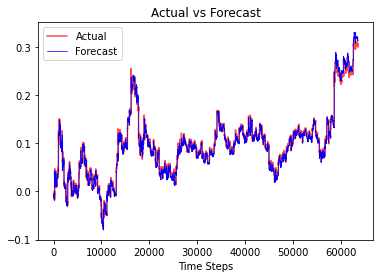

In [26]:
test_result3, truth3 = forecast_seq(model2, val_data3)

plt.plot(truth3, color='red', alpha=0.7)
plt.plot(test_result3, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

## Conclusion
Transformer model is able to train on a longer sequence compared to LSTM models (5 vs 10)  
Transformer model also trained faster, given the longer sequence length, and took lesser epochs to train the model

### Data Transforming and Normalising
Advantages of using cumulative sum of log returns compared to min-max scaler in normalising stocks prices,  
create better standardisation across stocks  
Training data augmentation allowed model to be trained on wider data points, resulting in the model generalising well across unseen data from test 2 and test 3  
Previous testing without data augmentation had models underperforming with higher loss